In [340]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

from datetime import timedelta  

%matplotlib inline


# Discrete data + probability
### Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.timestamp = df.timestamp.str.replace(r'\[|\]', '')

In [5]:
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 

In [6]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,2019-04-16 19:34:42,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,2019-04-16 19:34:42,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,2019-04-16 19:34:44,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,2019-04-16 19:34:46,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,2019-04-16 19:34:48,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [7]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

In [8]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,2019-04-16 19:34:42,GET /api/v1/sales?page=81 HTTP/1.1,200,512495,NaN,python-requests/2.21.0
1,97.105.19.58,2019-04-16 19:34:42,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2,97.105.19.58,2019-04-16 19:34:44,GET /api/v1/sales?page=82 HTTP/1.1,200,510103,NaN,python-requests/2.21.0
3,97.105.19.58,2019-04-16 19:34:46,GET /api/v1/sales?page=83 HTTP/1.1,200,510003,NaN,python-requests/2.21.0
4,97.105.19.58,2019-04-16 19:34:48,GET /api/v1/sales?page=84 HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [9]:
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

In [10]:
df.head(10)

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,2019-04-16 19:34:42,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
1,97.105.19.58,2019-04-16 19:34:42,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2,97.105.19.58,2019-04-16 19:34:44,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
3,97.105.19.58,2019-04-16 19:34:46,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
4,97.105.19.58,2019-04-16 19:34:48,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0
5,97.105.19.58,2019-04-16 19:34:48,GET /api/v1/stores HTTP/1.1,200,1328,NaN,python-requests/2.21.0
6,97.105.19.58,2019-04-16 19:34:50,GET /api/v1/sales HTTP/1.1,200,510753,NaN,python-requests/2.21.0
7,97.105.19.58,2019-04-16 19:34:52,GET /api/v1/sales HTTP/1.1,200,510348,NaN,python-requests/2.21.0
8,97.105.19.58,2019-04-16 19:34:52,GET / HTTP/1.1,200,42,NaN,python-requests/2.21.0
9,97.105.19.58,2019-04-16 19:34:53,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0


In [11]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [12]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


## Basic Probabilities

### Using request agent

In [13]:
agent_df = pd.DataFrame(df.request_agent.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'agent_count'})

In [14]:
agent_df

,request_agent,agent_count
0,python-requests/2.21.0,12005
1,python-requests/2.20.1,1911
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7
5,Slackbot 1.0 (+https://api.slack.com/robots),6
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2
8,Python-urllib/3.7,1


In [15]:
agent_df2 = pd.DataFrame(df.request_agent.value_counts(dropna=False)/df.request_agent.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'prob_agent'})

In [16]:
agent_df2

,request_agent,prob_agent
0,python-requests/2.21.0,0.858850
1,python-requests/2.20.1,0.136715
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.002432
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000143
8,Python-urllib/3.7,0.000072


In [17]:
agent_df = agent_df.merge(agent_df2, on='request_agent')

In [18]:
agent_df

,request_agent,agent_count,prob_agent
0,python-requests/2.21.0,12005,0.858850
1,python-requests/2.20.1,1911,0.136715
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.002432
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.000143
8,Python-urllib/3.7,1,0.000072


In [19]:
agent_df[agent_df.prob_agent < .01]


,request_agent,agent_count,prob_agent
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.002432
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.000143
8,Python-urllib/3.7,1,0.000072


### Using IP address

In [20]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})

In [21]:
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

In [22]:
ip_df = ip_df.merge(ip_df2)


In [23]:
ip_df[ip_df.ip_proba < .01]


,ip,ip_count,ip_proba
4,24.26.242.9,21,0.001502
5,68.201.219.223,21,0.001502
6,35.175.171.137,2,0.000143
7,52.87.230.102,2,0.000143
8,70.121.214.34,2,0.000143
9,34.207.64.242,1,0.000072
10,97.105.15.120,1,0.000072
11,3.88.129.158,1,0.000072
12,95.31.18.119,1,0.000072
13,54.145.52.184,1,0.000072


22
               ip  ip_count  ip_proba
12   95.31.18.119         1  0.000072
13  54.145.52.184         1  0.000072
14   95.31.16.121         1  0.000072
15  54.172.14.223         1  0.000072
16  52.90.165.200         1  0.000072
17   35.174.209.2         1  0.000072
18  34.229.70.250         1  0.000072
19   3.92.201.136         1  0.000072
20   52.91.30.150         1  0.000072
21   45.23.250.16         1  0.000072


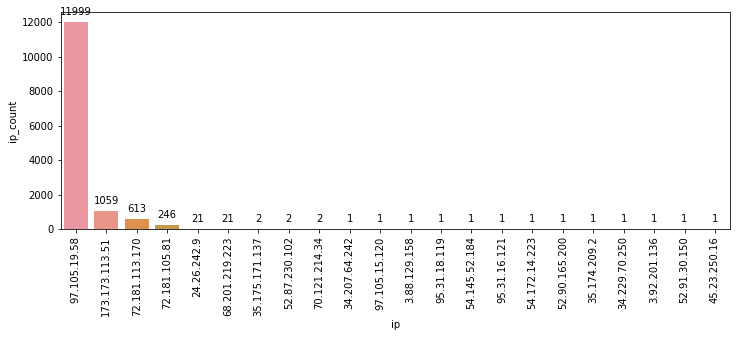

In [24]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

## Establish a baseline

In [25]:
df.dtypes

ip                        object
timestamp         datetime64[ns]
request_method            object
status                     int64
size                       int64
destination               object
request_agent             object
size_mb                  float64
dtype: object

In [26]:
df = df.set_index('timestamp')

In [27]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


In [28]:
train = df['2019-04-16 19:34:42':'2019-04-17 12:55:14'][['ip','request_method','status','size','destination','request_agent','size_mb']]

In [29]:
agent_df = pd.DataFrame(train.request_agent.value_counts(dropna=False)/train.request_agent.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'agent_proba'})

In [30]:
agent_df

,request_agent,agent_proba
0,python-requests/2.21.0,0.858809
1,python-requests/2.20.1,0.136754
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.002433
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000143
8,Python-urllib/3.7,0.000072


In [31]:
df = df.reset_index().merge(agent_df, on=['request_agent'], how='left').fillna(value=0).set_index('timestamp')
df.agent_proba.value_counts()

0.858809    12005
0.136754     1911
0.002433       34
0.000572        8
0.000501        7
0.000429        6
0.000286        4
0.000143        2
0.000072        1
Name: agent_proba, dtype: int64

## Conditional Probability

### Using request agent and status

In [32]:
agent_probs = train.groupby('request_agent').size().div(len(df))

status_given_agent = pd.DataFrame(train.groupby(['request_agent', 'status']).\
                               size().div(len(train)).\
                               div(agent_probs, 
                                   axis=0, 
                                   level='request_agent').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_agent'})
                              )

In [33]:
agent_status_count = pd.DataFrame(train.groupby(['request_agent', 'status'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'agent_status_count'}))


agent_status = status_given_agent.merge(agent_status_count)

In [34]:
df = df.reset_index().merge(agent_status, on=['request_agent', 'status'], how='left').fillna(value=0).set_index('timestamp')

In [35]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,agent_proba,proba_status_given_agent,agent_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858809,0.999286,11989.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858809,0.999286,11989.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858809,0.999286,11989.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858809,0.999286,11989.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858809,0.999286,11989.0


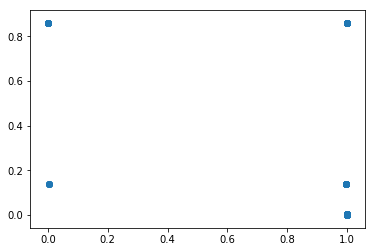

In [36]:
plt.scatter(df.proba_status_given_agent, df.agent_proba)


### Using IP address and status

In [37]:
ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

In [38]:
ip_probs = train.groupby('ip').size().div(len(df))

status_given_ip = pd.DataFrame(train.groupby(['ip', 'status']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_ip'})
                              )


In [39]:
ip_status_count = pd.DataFrame(train.groupby(['ip', 'status'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'ip_status_count'}))


ip_status = status_given_ip.merge(ip_status_count)

In [40]:
ip_df

,ip,ip_proba
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,24.26.242.9,0.001503
5,68.201.219.223,0.001503
6,35.175.171.137,0.000143
7,52.87.230.102,0.000143
8,70.121.214.34,0.000143
9,3.88.129.158,0.000072


In [41]:
df = df.reset_index().merge(ip_status, on=['ip', 'status'], how='left').fillna(value=0).set_index('timestamp')
df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')


In [42]:
df.head()


,ip,request_method,status,size,destination,request_agent,size_mb,agent_proba,proba_status_given_agent,agent_status_count,proba_status_given_ip,ip_status_count,ip_proba
timestamp,,,,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858809,0.999286,11989.0,0.999119,11984.0,0.858595
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858809,0.999286,11989.0,0.999119,11984.0,0.858595
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858809,0.999286,11989.0,0.999119,11984.0,0.858595
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858809,0.999286,11989.0,0.999119,11984.0,0.858595
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858809,0.999286,11989.0,0.999119,11984.0,0.858595


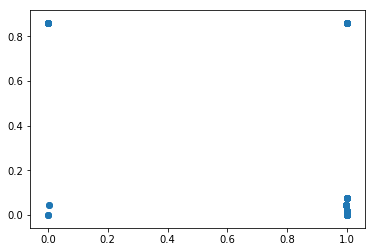

In [43]:
plt.scatter(df.proba_status_given_ip, df.ip_proba)


# Time series + EMA
## Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

In [44]:
import pandas as pd
import numpy as np
from datetime import datetime
import itertools

# JSON API
import requests
import json

# data visualization
import matplotlib
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()

In [45]:
path = '~/Documents/Coding/Codeup/Coursework/ds-methodologies-exercises/anomaly/'
file = 'anonymized-curriculum-access.txt'

In [46]:
col_names = ['date', 'timestamp', 'page', 'student_id', 'cohort_id', 'ip']

In [47]:
logs = pd.read_csv(path+file, engine='python',
                 header=None,
                 index_col=False,
                 names=col_names,
                 sep= ' ',
                 na_values='"-"')

In [48]:
logs

,date,timestamp,page,student_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
5,2018-01-26,09:56:41,javascript-i/loops,2,22.0,97.105.19.61
6,2018-01-26,09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61
7,2018-01-26,09:56:48,javascript-i/functions,3,22.0,97.105.19.61
8,2018-01-26,09:56:59,javascript-i/loops,2,22.0,97.105.19.61
9,2018-01-26,09:58:26,javascript-i/functions,4,22.0,97.105.19.61


In [49]:
logs['timestamp'] = logs.date+' '+logs.timestamp

In [50]:
logs = logs.drop(columns='date')

In [51]:
logs.dtypes

timestamp      object
page           object
student_id      int64
cohort_id     float64
ip             object
dtype: object

In [52]:
logs.timestamp = pd.to_datetime(logs.timestamp)

In [53]:
logs.describe()

,student_id,cohort_id
count,233528.000000,219070.000000
mean,191.155604,23.119149
std,111.150206,5.874320
min,1.000000,1.000000
25%,106.750000,22.000000
50%,202.000000,24.000000
75%,277.000000,26.000000
max,398.000000,31.000000


In [54]:
logs.set_index('timestamp', inplace=True)

In [55]:
logs.index.date

array([datetime.date(2018, 1, 26), datetime.date(2018, 1, 26),
       datetime.date(2018, 1, 26), ..., datetime.date(2019, 4, 2),
       datetime.date(2019, 4, 2), datetime.date(2019, 4, 2)], dtype=object)

In [56]:
logs.isnull().sum()

page              0
student_id        0
cohort_id     14458
ip                0
dtype: int64

In [57]:
logs.head(10)

,page,student_id,cohort_id,ip
timestamp,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61
2018-01-26 09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61
2018-01-26 09:56:48,javascript-i/functions,3,22.0,97.105.19.61
2018-01-26 09:56:59,javascript-i/loops,2,22.0,97.105.19.61


# Import data from cohort dates of attendance

In [168]:
coh_dates = pd.read_clipboard(sep=',')

In [169]:
coh_dates.describe()

,id
count,31.000000
mean,16.000000
std,9.092121
min,1.000000
25%,8.500000
50%,16.000000
75%,23.500000
max,31.000000


In [175]:
coh_dates = coh_dates.rename(columns={'id': 'cohort_id'})

In [253]:
coh_dates

,cohort_id,name,start_date,end_date
0,1,Arches,2014-02-04,2014-04-22
1,2,Badlands,2014-06-04,2014-08-22
2,3,Carlsbad,2014-09-04,2014-11-05
3,4,Denali,2014-10-20,2015-01-18
4,5,Everglades,2014-11-18,2015-02-24
5,6,Franklin,2015-02-03,2015-05-26
6,7,Glacier,2015-06-05,2015-10-06
7,8,Hampton,2015-09-22,2016-02-06
8,9,Apollo,2015-03-30,2015-07-29
9,10,Balboa,2015-11-03,2016-03-11


# Merge dataframes

In [176]:
new_df = pd.merge(logs, coh_dates, on='cohort_id', how='inner', right_index=True)

In [179]:
new_df.head(10)

,page,student_id,cohort_id,ip,name,start_date,end_date
timestamp,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 10:40:15,javascript-i/functions,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 11:26:13,java-i,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 11:43:17,mkdocs/search_index.json,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-27 07:49:25,teams/13,1,8.0,72.177.226.58,Hampton,2015-09-22,2016-02-06
2018-01-29 11:41:51,javascript-i/conditionals,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06


## Clean up some of the data

In [180]:
new_df['page'].replace(regex=r'^/$', value='home_page', inplace=True)

In [181]:
new_df.head()

,page,student_id,cohort_id,ip,name,start_date,end_date
timestamp,,,,,,,
2018-01-26 09:55:03,home_page,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 10:40:15,javascript-i/functions,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06


# How many cohorts are there? How many unique page views does each cohort have?

In [182]:
logs.cohort_id.count()

219070

In [183]:
coh_cnt = logs.groupby('cohort_id').agg(['count'])['page']
coh_cnt

,count
cohort_id,
1.0,8821
2.0,89
4.0,4
6.0,59
7.0,338
8.0,1671
9.0,5
11.0,79
12.0,230


In [184]:
coh_cnt.index

Float64Index([ 1.0,  2.0,  4.0,  6.0,  7.0,  8.0,  9.0, 11.0, 12.0, 13.0, 14.0,
              15.0, 16.0, 17.0, 18.0, 19.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0,
              27.0, 28.0, 29.0, 31.0],
             dtype='float64', name='cohort_id')

### How many null values are in cohort id?

In [185]:
logs.cohort_id.isnull().sum()

14458

# Selecting Cohort 24 ... 

In [186]:
coh24 = new_df[new_df.cohort_id == 24.0]

In [187]:
coh24.describe()

,student_id,cohort_id
count,34485.000000,34485.0
mean,196.132927,24.0
std,12.106069,0.0
min,182.000000,24.0
25%,188.000000,24.0
50%,194.000000,24.0
75%,202.000000,24.0
max,278.000000,24.0


In [188]:
coh24.isnull().sum()

page          0
student_id    0
cohort_id     0
ip            0
name          0
start_date    0
end_date      0
dtype: int64

In [189]:
coh24.index.date

array([datetime.date(2018, 5, 29), datetime.date(2018, 5, 29),
       datetime.date(2018, 5, 29), ..., datetime.date(2019, 3, 29),
       datetime.date(2019, 3, 29), datetime.date(2019, 3, 29)],
      dtype=object)

# Resample

In [190]:
coh24.resample('M').count()

,page,student_id,cohort_id,ip,name,start_date,end_date
timestamp,,,,,,,
2018-05-31,783,783,783,783,783,783,783
2018-06-30,8277,8277,8277,8277,8277,8277,8277
2018-07-31,8106,8106,8106,8106,8106,8106,8106
2018-08-31,11078,11078,11078,11078,11078,11078,11078
2018-09-30,4001,4001,4001,4001,4001,4001,4001
2018-10-31,634,634,634,634,634,634,634
2018-11-30,349,349,349,349,349,349,349
2018-12-31,375,375,375,375,375,375,375
2019-01-31,359,359,359,359,359,359,359


In [191]:
coh24.resample('W').count()

,page,student_id,cohort_id,ip,name,start_date,end_date
timestamp,,,,,,,
2018-06-03,1498,1498,1498,1498,1498,1498,1498
2018-06-10,1576,1576,1576,1576,1576,1576,1576
2018-06-17,1955,1955,1955,1955,1955,1955,1955
2018-06-24,1907,1907,1907,1907,1907,1907,1907
2018-07-01,2242,2242,2242,2242,2242,2242,2242
2018-07-08,1116,1116,1116,1116,1116,1116,1116
2018-07-15,2202,2202,2202,2202,2202,2202,2202
2018-07-22,1605,1605,1605,1605,1605,1605,1605
2018-07-29,2304,2304,2304,2304,2304,2304,2304


## Fill in missing data from resampling

In [192]:
my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')

coh24_size = coh24['page'].resample('W').count()


In [193]:
idx2 = pd.date_range(
    coh24_size.sort_index().index.min(), 
    coh24_size.sort_index().index.max(),
    freq='W')

coh24_size = coh24_size.reindex(idx2, fill_value=0).fillna(value=0)

## Split Train / Test 

In [194]:
coh24_size.head(1)

2018-06-03    1498
Freq: W-SUN, Name: page, dtype: int64

In [195]:
start_date_train = coh24_size.head(1).index[0]
start_date_train

Timestamp('2018-06-03 00:00:00', freq='W-SUN')

In [196]:
coh24_size['2018-11-06':]

2018-11-11     87
2018-11-18     86
2018-11-25     52
2018-12-02     23
2018-12-09     42
2018-12-16     51
2018-12-23    155
2018-12-30     84
2019-01-06     85
2019-01-13     87
2019-01-20     57
2019-01-27    140
2019-02-03     38
2019-02-10     38
2019-02-17     99
2019-02-24    121
2019-03-03    101
2019-03-10     39
2019-03-17     94
2019-03-24     13
2019-03-31      8
Freq: W-SUN, Name: page, dtype: int64

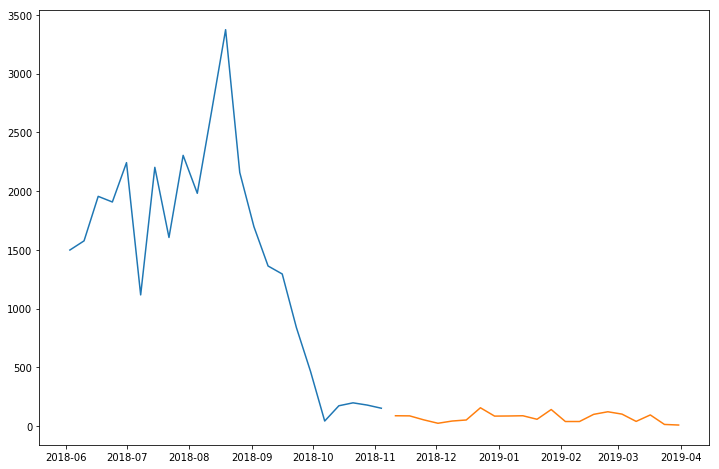

In [197]:
train = coh24_size[:'2018-11-05']
test = coh24_size['2018-11-06':]

plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(test)
plt.show()

# SMA - Simple Moving Average


In [198]:
# Calculating the short-window simple moving average
short_rolling = train.rolling(window=2).mean()

# Calculating the long-window simple moving average
long_rolling = train.rolling(window=4).mean()

Text(0, 0.5, 'Size (MB)')

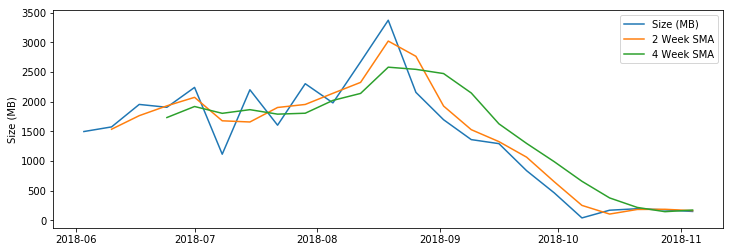

In [199]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '2 Week SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '4 Week SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

# Exponential Moving Average


In [200]:
# Using Pandas to calculate a 2 week span EMA. 
# adjust=False specifies that we are interested in the 
# recursive calculation mode.
ema_short = train.ewm(span=2, adjust=False).mean()
ema_short[0:3]

ema_long = train.ewm(span=4, adjust=False).mean()
ema_long[0:3]

2018-06-03    1498.00
2018-06-10    1529.20
2018-06-17    1699.52
Freq: W-SUN, Name: page, dtype: float64

In [201]:
ema_short[0:3]

2018-06-03    1498.0
2018-06-10    1550.0
2018-06-17    1820.0
Freq: W-SUN, Name: page, dtype: float64

In [202]:
ema_long[0:3]

2018-06-03    1498.00
2018-06-10    1529.20
2018-06-17    1699.52
Freq: W-SUN, Name: page, dtype: float64

In [203]:
span = 4
ema_long = train.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

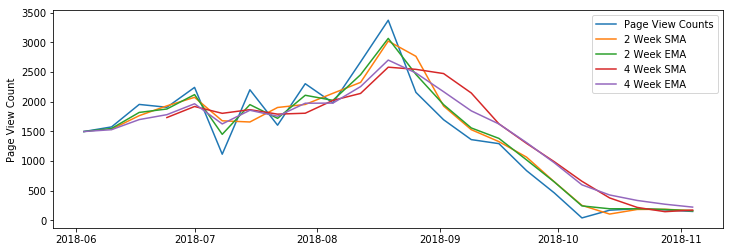

In [204]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Page View Counts')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '2 Week SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = '2 Week EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '4 Week SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = '4 Week EMA')

ax.legend(loc='best')
ax.set_ylabel('Page View Count')

yhat = pd.DataFrame(dict(actual=test))

### Forecast using the EMA


In [205]:
span = 4
ema_long = train.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

yhat['moving_avg_forecast'] = midband

### Compute the '%b' for each record


In [206]:
# compute the absolute error:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

# compute the mean of the absolute error:
# yhat.error.median()

# compute upper band and lower band using IQR with weight of 3

yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

### Extract the anomalies


In [207]:
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b


In [208]:
yhat[yhat.pct_b < 1]

,actual,moving_avg_forecast,error,pct_b
2018-11-11,87,224.103231,137.103231,0.466164
2018-11-18,86,224.103231,138.103231,0.465918
2018-11-25,52,224.103231,172.103231,0.457527
2018-12-02,23,224.103231,201.103231,0.450370
2018-12-09,42,224.103231,182.103231,0.455059
2018-12-16,51,224.103231,173.103231,0.457280
2018-12-23,155,224.103231,69.103231,0.482946
2018-12-30,84,224.103231,140.103231,0.465424
2019-01-06,85,224.103231,139.103231,0.465671
2019-01-13,87,224.103231,137.103231,0.466164


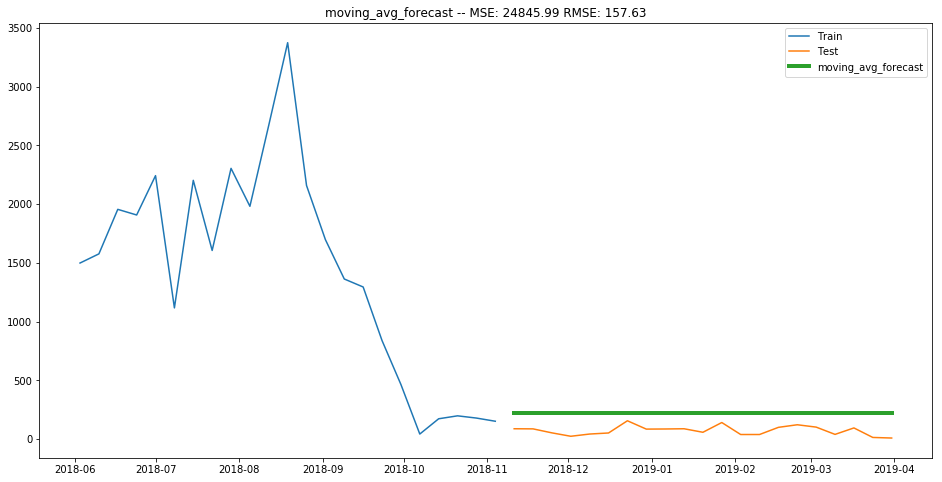

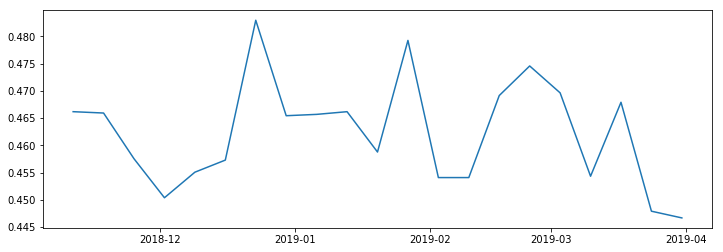

In [209]:
plot_and_eval(yhat.moving_avg_forecast, actual=test)
plt.figure(figsize=(12,4))
plt.plot(yhat.pct_b)

# Trying to automate the exploration process across all the cohorts

In [210]:
cohorts = [1.0,  2.0,  4.0,  6.0,  7.0,  8.0,  9.0, 11.0, 12.0, 13.0, 14.0,
              15.0, 16.0, 17.0, 18.0, 19.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0,
              27.0, 28.0, 29.0, 31.0]

In [211]:
cohort_dfs = []
for element in cohorts:
    element = logs[logs.cohort_id == element]
    cohort_dfs.append(element)
cohort_dfs

[                                                                  page  \
 timestamp                                                                
 2018-01-26 10:14:47                                                  /   
 2018-01-26 10:14:51                                       javascript-i   
 2018-01-26 10:15:02                             javascript-i/functions   
 2018-01-26 11:46:29  appendix/further-reading/javascript/hoisting.html   
 2018-01-26 11:46:39                                           appendix   
 2018-01-26 11:46:47       appendix/further-reading/javascript/hoisting   
 2018-01-26 11:47:01                         appendix/capstone-workbook   
 2018-01-26 11:47:03                                       javascript-i   
 2018-01-26 11:47:05                             javascript-i/functions   
 2018-01-26 12:10:30                          javascript-i/conditionals   
 2018-01-26 12:10:41                                 javascript-i/loops   
 2018-01-26 12:10:44     

In [212]:
cohort_dfs[0]

,page,student_id,cohort_id,ip
timestamp,,,,
2018-01-26 10:14:47,/,11,1.0,97.105.19.61
2018-01-26 10:14:51,javascript-i,11,1.0,97.105.19.61
2018-01-26 10:15:02,javascript-i/functions,11,1.0,97.105.19.61
2018-01-26 11:46:29,appendix/further-reading/javascript/hoisting.html,11,1.0,97.105.19.61
2018-01-26 11:46:39,appendix,11,1.0,97.105.19.61
2018-01-26 11:46:47,appendix/further-reading/javascript/hoisting,11,1.0,97.105.19.61
2018-01-26 11:47:01,appendix/capstone-workbook,11,1.0,97.105.19.61
2018-01-26 11:47:03,javascript-i,11,1.0,97.105.19.61
2018-01-26 11:47:05,javascript-i/functions,11,1.0,97.105.19.61


# Selecting Cohort 25...

In [213]:
coh25 = new_df[new_df.cohort_id == 25.0]

In [214]:
coh25.describe()

,student_id,cohort_id
count,24681.000000,24681.0
mean,232.948908,25.0
std,12.423168,0.0
min,218.000000,25.0
25%,225.000000,25.0
50%,231.000000,25.0
75%,236.000000,25.0
max,282.000000,25.0


In [215]:
coh25.isnull().sum()

page          0
student_id    0
cohort_id     0
ip            0
name          0
start_date    0
end_date      0
dtype: int64

In [216]:
coh25.head()

,page,student_id,cohort_id,ip,name,start_date,end_date
timestamp,,,,,,,
2018-07-23 13:51:26,registerUser,218,25.0,97.105.19.58,Wrangell,2018-07-23,2018-11-29
2018-07-23 13:51:39,registerUser,218,25.0,97.105.19.58,Wrangell,2018-07-23,2018-11-29
2018-07-23 15:15:19,home_page,219,25.0,97.105.19.58,Wrangell,2018-07-23,2018-11-29
2018-07-23 15:15:20,home_page,220,25.0,97.105.19.58,Wrangell,2018-07-23,2018-11-29
2018-07-23 15:15:21,home_page,221,25.0,97.105.19.58,Wrangell,2018-07-23,2018-11-29


# Resample

In [217]:
coh25.resample('M').count()

,page,student_id,cohort_id,ip,name,start_date,end_date
timestamp,,,,,,,
2018-07-31,2304,2304,2304,2304,2304,2304,2304
2018-08-31,8062,8062,8062,8062,8062,8062,8062
2018-09-30,5881,5881,5881,5881,5881,5881,5881
2018-10-31,6086,6086,6086,6086,6086,6086,6086
2018-11-30,1794,1794,1794,1794,1794,1794,1794
2018-12-31,119,119,119,119,119,119,119
2019-01-31,127,127,127,127,127,127,127
2019-02-28,259,259,259,259,259,259,259
2019-03-31,49,49,49,49,49,49,49


## Fill in missing data from resampling

In [218]:
my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')

coh25_size = coh25['page'].resample('W').count()


In [219]:
idx3 = pd.date_range(
    coh25_size.sort_index().index.min(), 
    coh25_size.sort_index().index.max(),
    freq='W')

coh25_size = coh25_size.reindex(idx3, fill_value=0).fillna(value=0)

## Split Train / Test 

In [220]:
coh25_size.head(1)

2018-07-29    1704
Freq: W-SUN, Name: page, dtype: int64

In [221]:
start_date_train = coh25_size.head(1).index[0]
start_date_train

Timestamp('2018-07-29 00:00:00', freq='W-SUN')

In [222]:
coh25_size['2018-11-06':]

2018-11-11    765
2018-11-18    297
2018-11-25    113
2018-12-02    250
2018-12-09     78
2018-12-16     19
2018-12-23     12
2018-12-30      0
2019-01-06     71
2019-01-13      0
2019-01-20     25
2019-01-27     17
2019-02-03     16
2019-02-10     17
2019-02-17    221
2019-02-24     18
2019-03-03      1
2019-03-10     24
2019-03-17     10
2019-03-24      8
2019-03-31      7
Freq: W-SUN, Name: page, dtype: int64

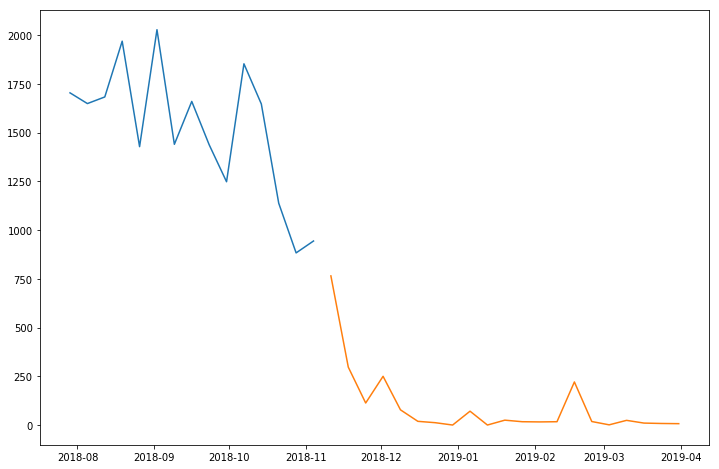

In [223]:
train2 = coh25_size[:'2018-11-05']
test2 = coh25_size['2018-11-06':]

plt.figure(figsize=(12, 8))
plt.plot(train2)
plt.plot(test2)
plt.show()

# SMA - Simple Moving Average


In [224]:
# Calculating the short-window simple moving average
short_rolling2 = train2.rolling(window=2).mean()

# Calculating the long-window simple moving average
long_rolling2 = train2.rolling(window=4).mean()

Text(0, 0.5, 'Page View Count')

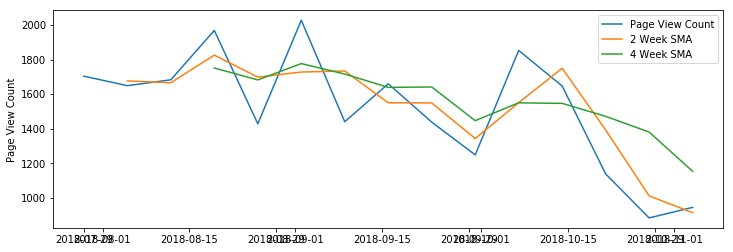

In [225]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train2.index, 
        train2,
        label='Page View Count')

ax.plot(short_rolling2.index, 
        short_rolling2, 
        label = '2 Week SMA')
ax.plot(long_rolling2.index, 
        long_rolling2, 
        label = '4 Week SMA')

ax.legend(loc='best')
ax.set_ylabel('Page View Count')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

# Exponential Moving Average


In [226]:
# Using Pandas to calculate a 2 week span EMA. 
# adjust=False specifies that we are interested in the 
# recursive calculation mode.
ema_short = train2.ewm(span=2, adjust=False).mean()
ema_short[0:3]

ema_long = train2.ewm(span=4, adjust=False).mean()
ema_long[0:3]

2018-07-29    1704.0
2018-08-05    1682.0
2018-08-12    1682.4
Freq: W-SUN, Name: page, dtype: float64

In [227]:
ema_short[0:3]

2018-07-29    1704.000000
2018-08-05    1667.333333
2018-08-12    1677.777778
Freq: W-SUN, Name: page, dtype: float64

In [228]:
ema_long[0:3]

2018-07-29    1704.0
2018-08-05    1682.0
2018-08-12    1682.4
Freq: W-SUN, Name: page, dtype: float64

In [229]:
span = 4
ema_long = train2.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

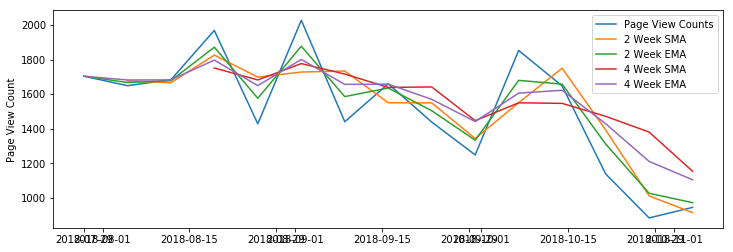

In [230]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train2.index, 
        train2,
        label='Page View Counts')

ax.plot(short_rolling2.index, 
        short_rolling2, 
        label = '2 Week SMA')
ax.plot(long_rolling2.index, 
        ema_short, 
        label = '2 Week EMA')
ax.plot(long_rolling2.index, 
        long_rolling2, 
        label = '4 Week SMA')
ax.plot(long_rolling2.index, 
        ema_long, 
        label = '4 Week EMA')

ax.legend(loc='best')
ax.set_ylabel('Page View Count')

yhat = pd.DataFrame(dict(actual=test2))

### Forecast using the EMA


In [231]:
span = 4
ema_long = train2.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

yhat['moving_avg_forecast'] = midband

### Compute the '%b' for each record


In [232]:
# compute the absolute error:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

# compute the mean of the absolute error:
# yhat.error.median()

# compute upper band and lower band using IQR with weight of 3

yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

### Extract the anomalies


In [233]:
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b


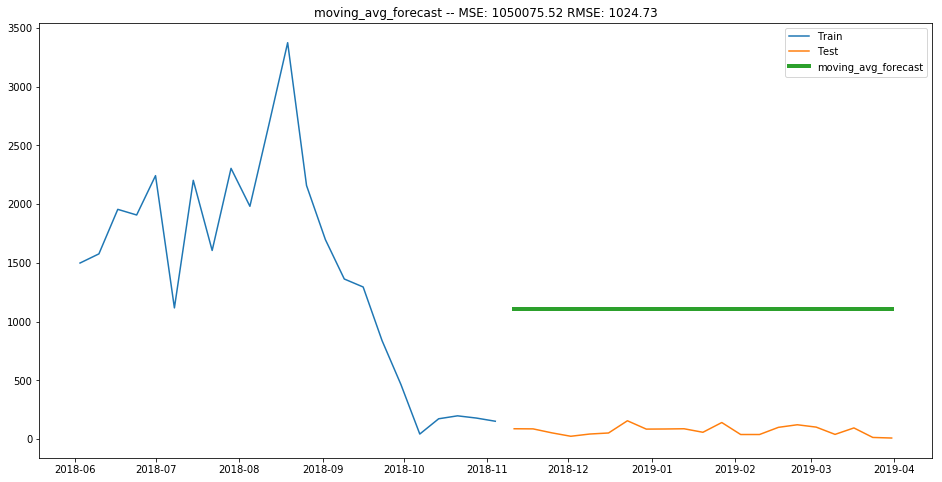

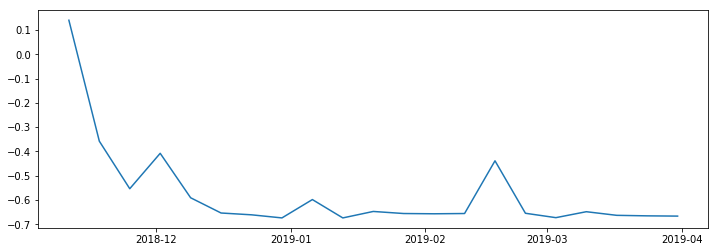

In [234]:
plot_and_eval(yhat.moving_avg_forecast, actual=test2)
plt.figure(figsize=(12,4))
plt.plot(yhat.pct_b)

## Plot the SMA and EMA with the 'fake' data that simulates usage when the cohort was in attendance (in school)

In [259]:
coh_dates[(coh_dates.cohort_id == 25)]['start_date'].values[0]

'2018-07-23'

In [254]:
coh_dates

,cohort_id,name,start_date,end_date
0,1,Arches,2014-02-04,2014-04-22
1,2,Badlands,2014-06-04,2014-08-22
2,3,Carlsbad,2014-09-04,2014-11-05
3,4,Denali,2014-10-20,2015-01-18
4,5,Everglades,2014-11-18,2015-02-24
5,6,Franklin,2015-02-03,2015-05-26
6,7,Glacier,2015-06-05,2015-10-06
7,8,Hampton,2015-09-22,2016-02-06
8,9,Apollo,2015-03-30,2015-07-29
9,10,Balboa,2015-11-03,2016-03-11


In [288]:
days = pd.date_range(start=coh_dates[(coh_dates.cohort_id == 25)]['start_date'].values[0], end=coh_dates[(coh_dates.cohort_id == 25)]['end_date'].values[0], freq='D')

np.random.seed(seed=1111)
data = np.random.randint(2400, high=2500, size=len(days))
dummy_df_coh25 = pd.DataFrame({'test': days, 'cohort25': data})
dummy_df_coh25 = dummy_df_coh25.set_index('test')
dummy_df_coh25

,cohort25
test,
2018-07-23,2428
2018-07-24,2455
2018-07-25,2481
2018-07-26,2412
2018-07-27,2434
2018-07-28,2452
2018-07-29,2424
2018-07-30,2422
2018-07-31,2420


In [277]:
dummy_df_coh25.dtypes

cohort25    int64
dtype: object

In [278]:
dummy_df_coh25 = dummy_df_coh25.reset_index()

In [279]:
dummy_df_coh25.test = pd.to_datetime(dummy_df_coh25.test)

In [280]:
dummy_df_coh25.head()

,test,cohort25
0,2018-07-23,2428
1,2018-07-24,2455
2,2018-07-25,2481
3,2018-07-26,2412
4,2018-07-27,2434


In [281]:
dummy_df_coh25 = dummy_df_coh25.set_index('test')

In [282]:
dummy_df_coh25


,cohort25
test,
2018-07-23,2428
2018-07-24,2455
2018-07-25,2481
2018-07-26,2412
2018-07-27,2434
2018-07-28,2452
2018-07-29,2424
2018-07-30,2422
2018-07-31,2420


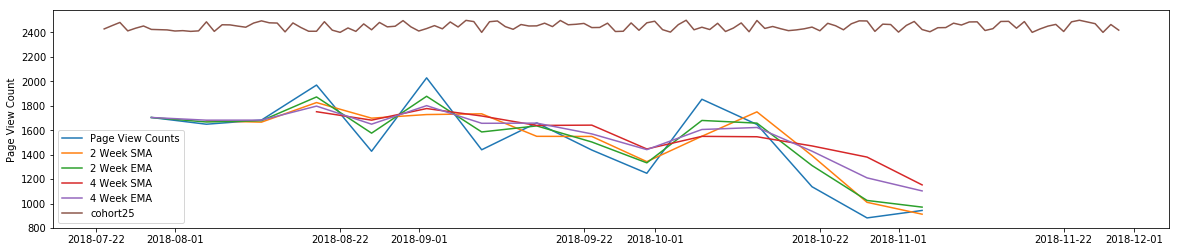

In [284]:
fig, ax = plt.subplots(figsize=(20,4))

ax.plot(train2.index, 
        train2,
        label='Page View Counts')

ax.plot(short_rolling2.index, 
        short_rolling2, 
        label = '2 Week SMA')
ax.plot(long_rolling2.index, 
        ema_short, 
        label = '2 Week EMA')
ax.plot(long_rolling2.index, 
        long_rolling2, 
        label = '4 Week SMA')
ax.plot(long_rolling2.index, 
        ema_long, 
        label = '4 Week EMA')
ax.plot(dummy_df_coh25.index,
       dummy_df_coh25.cohort25)

ax.legend(loc='best')
ax.set_ylabel('Page View Count')

yhat = pd.DataFrame(dict(actual=test))

# Selecting Cohort 26...

In [289]:
coh26 = new_df[new_df.cohort_id == 26.0]

In [290]:
coh26.describe()

,student_id,cohort_id
count,24088.000000,24088.0
mean,269.920832,26.0
std,8.484812,0.0
min,259.000000,26.0
25%,264.000000,26.0
50%,270.000000,26.0
75%,274.000000,26.0
max,315.000000,26.0


In [291]:
coh26.isnull().sum()

page          0
student_id    0
cohort_id     0
ip            0
name          0
start_date    0
end_date      0
dtype: int64

In [292]:
coh26.head()

,page,student_id,cohort_id,ip,name,start_date,end_date
timestamp,,,,,,,
2018-09-17 14:12:28,home_page,259,26.0,97.105.19.58,Xanadu,2018-09-17,2019-02-08
2018-09-17 14:13:38,home_page,260,26.0,97.105.19.58,Xanadu,2018-09-17,2019-02-08
2018-09-17 14:13:42,html-css,260,26.0,97.105.19.58,Xanadu,2018-09-17,2019-02-08
2018-09-17 14:13:58,home_page,261,26.0,97.105.19.58,Xanadu,2018-09-17,2019-02-08
2018-09-17 14:14:21,home_page,262,26.0,97.105.19.58,Xanadu,2018-09-17,2019-02-08


# Resample

In [293]:
coh26.resample('W').count()

,page,student_id,cohort_id,ip,name,start_date,end_date
timestamp,,,,,,,
2018-09-23,1427,1427,1427,1427,1427,1427,1427
2018-09-30,1130,1130,1130,1130,1130,1130,1130
2018-10-07,1350,1350,1350,1350,1350,1350,1350
2018-10-14,1283,1283,1283,1283,1283,1283,1283
2018-10-21,1280,1280,1280,1280,1280,1280,1280
2018-10-28,1703,1703,1703,1703,1703,1703,1703
2018-11-04,1123,1123,1123,1123,1123,1123,1123
2018-11-11,1641,1641,1641,1641,1641,1641,1641
2018-11-18,915,915,915,915,915,915,915


# Selecting Cohort 27...

In [299]:
coh27 = new_df[new_df.cohort_id == 27.0]

In [300]:
coh27.describe()

,student_id,cohort_id
count,19255.000000,19255.0
mean,299.831576,27.0
std,8.216223,0.0
min,287.000000,27.0
25%,293.000000,27.0
50%,302.000000,27.0
75%,305.000000,27.0
max,371.000000,27.0


In [301]:
coh27.isnull().sum()

page          0
student_id    0
cohort_id     0
ip            0
name          0
start_date    0
end_date      0
dtype: int64

In [302]:
coh27.head()

,page,student_id,cohort_id,ip,name,start_date,end_date
timestamp,,,,,,,
2018-11-05 14:03:58,home_page,287,27.0,97.105.19.58,Yosemite,2018-11-05,2019-04-03
2018-11-05 14:04:58,home_page,288,27.0,97.105.19.58,Yosemite,2018-11-05,2019-04-03
2018-11-05 14:05:18,home_page,289,27.0,97.105.19.58,Yosemite,2018-11-05,2019-04-03
2018-11-05 14:06:41,home_page,290,27.0,97.105.19.58,Yosemite,2018-11-05,2019-04-03
2018-11-05 14:06:51,home_page,291,27.0,97.105.19.58,Yosemite,2018-11-05,2019-04-03


In [316]:
## This function makes a new dataframe based on which cohort id you pass it.

In [317]:
def make_cohort_df(n):
    n = new_df[new_df.cohort_id == n]
    return n

In [318]:
coh29 = make_cohort_df(29)

In [303]:
## This function creates some 'dummy' data that simulates site usage when the class was in session. 
## Depending on the start and end dates of each cohort.

In [308]:
def dummy_data(n):
    
    days = pd.date_range(start=coh_dates[(coh_dates.cohort_id == n)]['start_date'].values[0], end=coh_dates[(coh_dates.cohort_id == n)]['end_date'].values[0], freq='D')
    np.random.seed(seed=1111)
    data = np.random.randint(2400, high=2500, size=len(days))
    dummy_df = pd.DataFrame({'test': days, n: data})
    dummy_df = dummy_df.set_index('test')
    dummy_df = dummy_df.reset_index()
    dummy_df.test = pd.to_datetime(dummy_df.test)
    dummy_df = dummy_df.set_index('test')
    return dummy_df

In [314]:
coh29_dummy = dummy_data(29)

In [348]:
coh29_dummy

,29
test,
2019-01-22,2428
2019-01-23,2455
2019-01-24,2481
2019-01-25,2412
2019-01-26,2434
2019-01-27,2452
2019-01-28,2424
2019-01-29,2422
2019-01-30,2420


In [320]:
## This function takes the dataframe and resamples it according to an interval specified

In [321]:
def resample_df(df, interval):
    df_resample = df['page'].resample(interval).count()
    return df

In [330]:
coh29 = resample_df(coh29, 'W')

In [333]:
length = coh29.index[-1] - coh29.index[0]
length * 0.75

Timedelta('52 days 09:00:18.750000')

In [329]:
## This function splits the dataframe into a train and test dataframe based on the timestamp index length

In [343]:
def train_test_split(df):
    size = df['page'].resample('W').count()
    length = df.index[-1] - df.index[0]
    start_date_train = size.head(1).index[0]
    end_date_train = size.head(1).index[0] + (length * 0.75)
    start_date_test = size.head(1).index[0] + (length * 0.75 + timedelta(seconds=1))
    end_date_test = size.head(1).index[-1]
    train = df[:end_date_train]
    test = df[start_date_test:]
    return train, test

In [346]:
train_29 = train_test_split(coh29)[0]

In [347]:
test_29 = train_test_split(coh29)[1]

In [352]:
def make_SMA_EMA_plots(train, dummy):
    # Calculating the short-window simple moving average
    short_rolling2 = train.rolling(window=2).mean()

    # Calculating the long-window simple moving average
    long_rolling2 = train.rolling(window=4).mean()

    # Using Pandas to calculate a 2 week span EMA. 
    # adjust=False specifies that we are interested in the 
    # recursive calculation mode.
    ema_short = train.ewm(span=2, adjust=False).mean()
    ema_long = train.ewm(span=4, adjust=False).mean()

    span = 4
    ema_long = train.ewm(span=span, adjust=False).mean()
    midband = ema_long[-1]
    ub = midband + ema_long[-24:-1].std()*3
    lb = midband - ema_long[-24:-1].std()*3
    fig, ax = plt.subplots(figsize=(20,4))

    ax.plot(train.index, 
            train,
            label='Page View Counts')

    ax.plot(short_rolling2.index, 
            short_rolling2, 
            label = '2 Week SMA')
    ax.plot(long_rolling2.index, 
            ema_short, 
            label = '2 Week EMA')
    ax.plot(long_rolling2.index, 
            long_rolling2, 
            label = '4 Week SMA')
    ax.plot(long_rolling2.index, 
            ema_long, 
            label = '4 Week EMA')
    ax.plot(dummy_5.index,
           dummy.iloc[:,0])

    ax.legend(loc='best')
    ax.set_ylabel('Page View Count')

    yhat = pd.DataFrame(dict(actual=test))


In [353]:
make_SMA_EMA_plots(train_29, coh29_dummy)

TypeError: cannot handle this type -> object

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))

ax.plot(train2.index, 
        train2,
        label='Page View Counts')

ax.plot(short_rolling2.index, 
        short_rolling2, 
        label = '2 Week SMA')
ax.plot(long_rolling2.index, 
        ema_short, 
        label = '2 Week EMA')
ax.plot(long_rolling2.index, 
        long_rolling2, 
        label = '4 Week SMA')
ax.plot(long_rolling2.index, 
        ema_long, 
        label = '4 Week EMA')
ax.plot(dummy_df_coh25.index,
       dummy_df_coh25.cohort25)

ax.legend(loc='best')
ax.set_ylabel('Page View Count')

yhat = pd.DataFrame(dict(actual=test))